# Data visualization throttled:
Unthrottled memory power = ~3000

| # | Setting |
| --- | --- |
| Device | macbook pro 14-inch, 2023 | 
| Chip | Apple M2 Pro | 
| Memory | 16 GB | 
| macOS | 15.1.1 | 
| Java | openjdk 21.0.5 | 
| Node | v23.3.0 | 
| Angular | v18.2.x | 

## Throttling

| # | Setting |
| --- | --- |
| CPU | 4x CPU slowdown | 
| download | 1.6 Mbps | 
| upload | 750 Kbps | 
| latency | 150ms | 

## Core Web Vitals Measurements:

**Long task**
- Task that takes more than 50ms

**TTFB (Time to First Byte):**
 - Time from navigation start until the first byte of response is received
 - Calculated using: performance.getEntriesByType('navigation')[0].responseStart
 
**FCP (First Contentful Paint):**
 - Time when the first text, image, or other content appears on the screen.
 - Is the 'endTime' of the first-contentful-paint
 - FCP includes all things that happened before it (like TTFB).
 
**LCP (Largest Contentful Paint):**
 - Time when the largest text or image element is rendered on the screen (so endTime)
 - Is the 'endTime' of the largest-contentful-paint.
 - FCP includes all things that happened before it (like TTFB).
 
**TTI (Time to Interactive):**
 - Time when the page becomes 'reliably' interactive
 - It is measured as the endtime of the last 'long task' after the FCP starttime
 - If no tasks are found, it is the end-time of the FCP.
 
**TBT (Total Blocking Time):**
 - Sum of all "blocking time" for long tasks between start of FCP and TTI
 - Blocking time = accumulation of (task duration - 50ms) of each long task.
 - TBT contains a 'quiet window' of 5s, if this window is expired, the test will end.
 - The quiet window starts after the FCP. 

In [1]:
run8path = '../../../data/core-web-vitals/testrun-8'

In [2]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

pd.set_option('display.float_format', lambda x: '%.2f' % x)


dataset_A = pd.read_csv(f'{run8path}/results-csr.csv', sep=',')
dataset_B = pd.read_csv(f'{run8path}/results-ssrh.csv', sep=',')
dataset_C = pd.read_csv(f'{run8path}/results-ssrv-sd.csv', sep=',')

features = ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask', 'longTasks', 'nf:init', 'nf:config', 'nf:loaded']
target_features = ['ttfb', 'fcp', 'lcp', 'tti', 'tbt', 'nf:init', 'nf:loaded']

# Remove Java warmup
dataset_A = dataset_A.iloc[5:]
dataset_B = dataset_B.iloc[5:]

datasets =	{
  "csr": dataset_A,
  "ssrh": dataset_B,
  "ssrv": dataset_C
}

dataset_B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 5 to 504
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   idx          500 non-null    int64  
 1   site         500 non-null    object 
 2   date         500 non-null    object 
 3   time         500 non-null    object 
 4   navTime      500 non-null    int64  
 5   totalTime    500 non-null    int64  
 6   lcp          500 non-null    float64
 7   fcp          500 non-null    float64
 8   ttfb         500 non-null    float64
 9   tbt          500 non-null    int64  
 10  tti          500 non-null    float64
 11  longTasks    500 non-null    int64  
 12  longestTask  500 non-null    int64  
 13  nf:init      500 non-null    float64
 14  nf:config    500 non-null    float64
 15  nf:loaded    500 non-null    float64
 16  error        0 non-null      float64
dtypes: float64(8), int64(6), object(3)
memory usage: 66.5+ KB


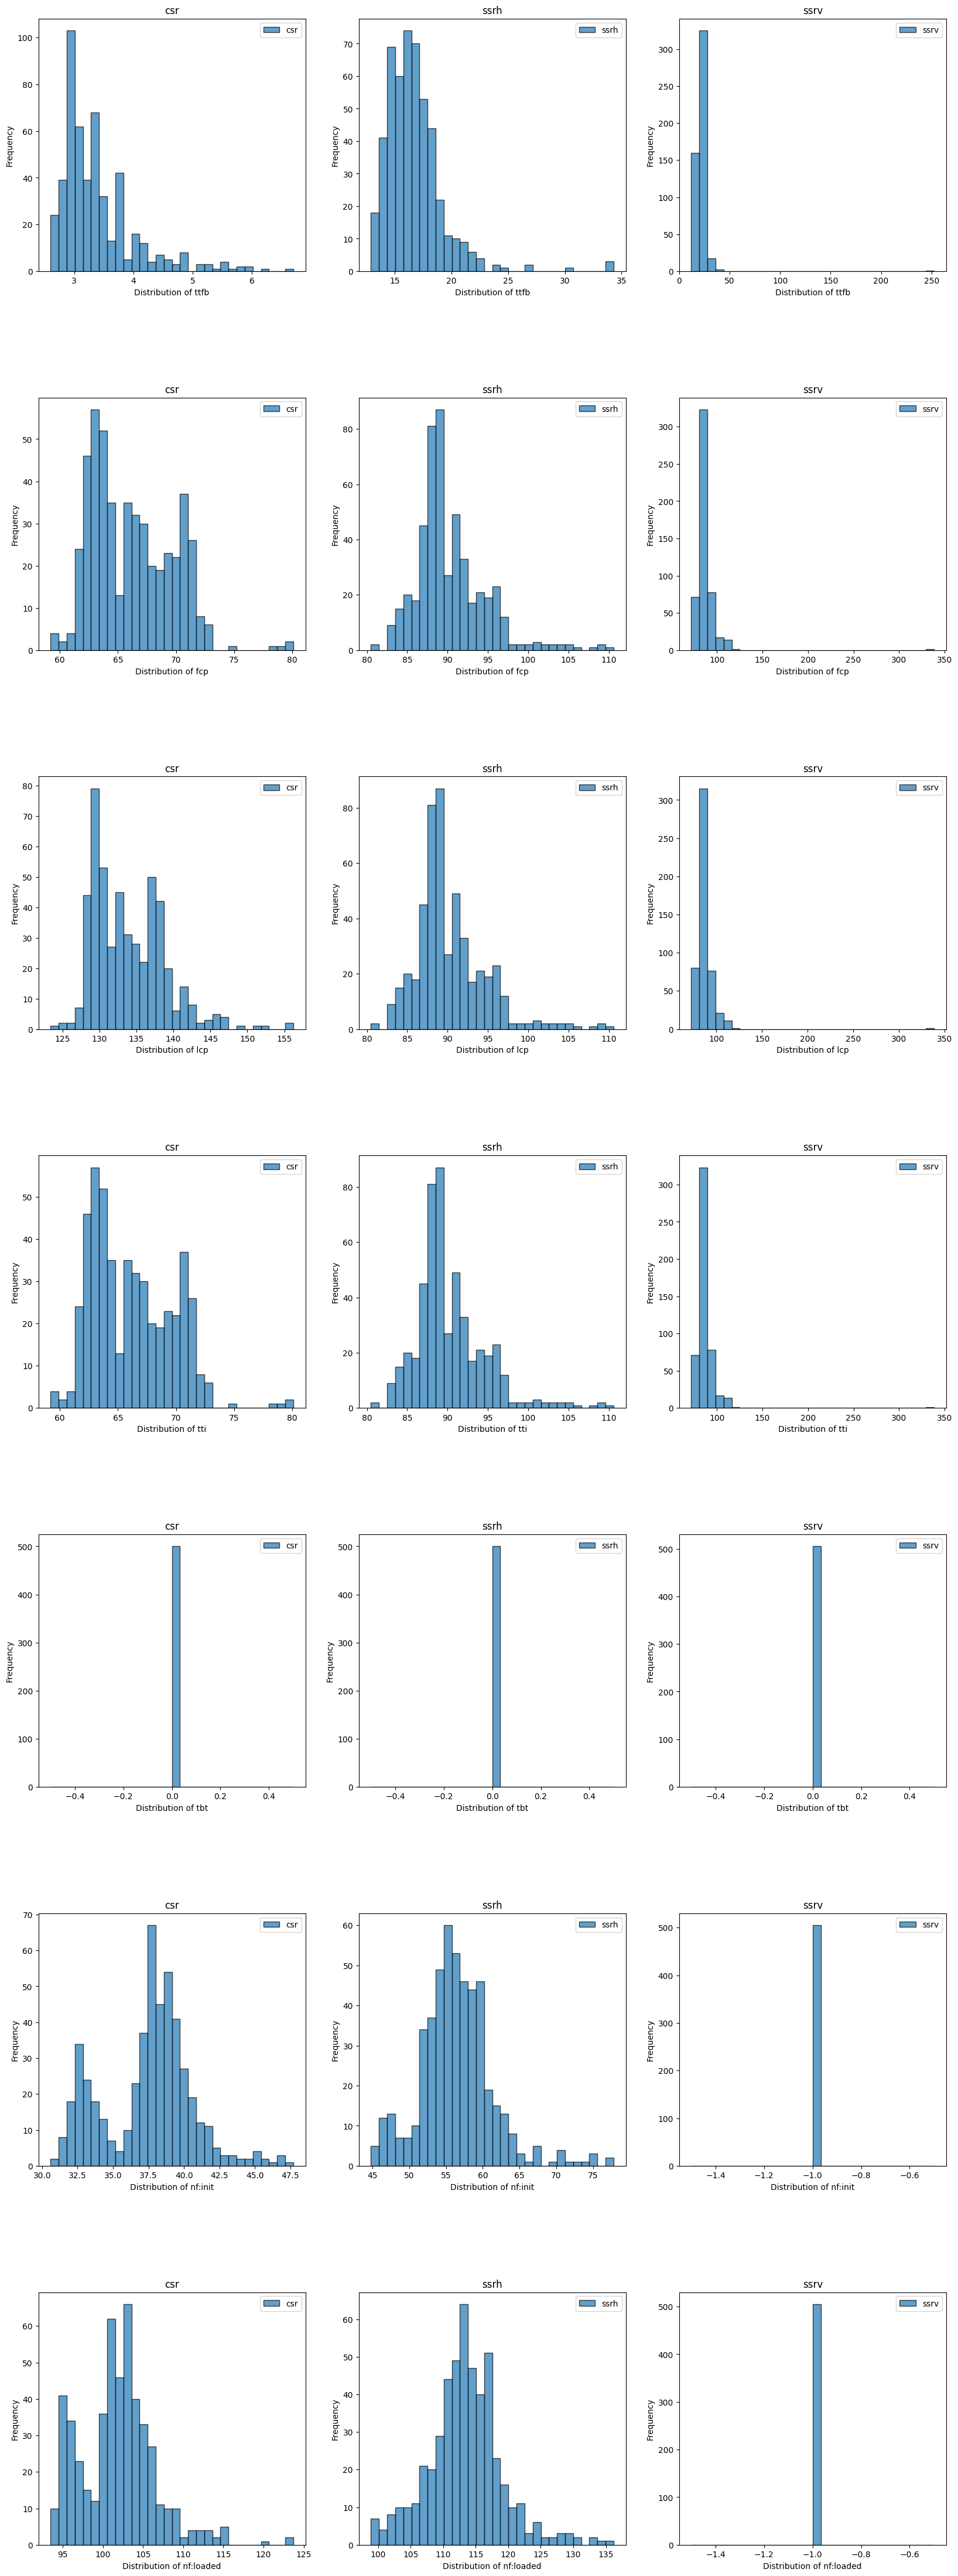

In [3]:

def plot_histogram(d, f, loc):
    loc.hist(datasets[d][f].dropna(), bins=30, alpha=0.7, label=d, edgecolor='k')
    loc.set_title(d)
    loc.set_ylabel('Frequency')
    loc.set_xlabel(f'Distribution of {f}')
    loc.legend()

def graphs(plot_func, features, height=8):
    rows = len(features)
    cols = len(datasets)

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_func(d, f, axes[y, x])
    return plt

plt = graphs(plot_histogram, target_features)
plt.show()

      Total Points  Outliers Percentage Removed
csr            500        50              10.0%
ssrh           500        50              10.0%
ssrv           505        51              10.1%


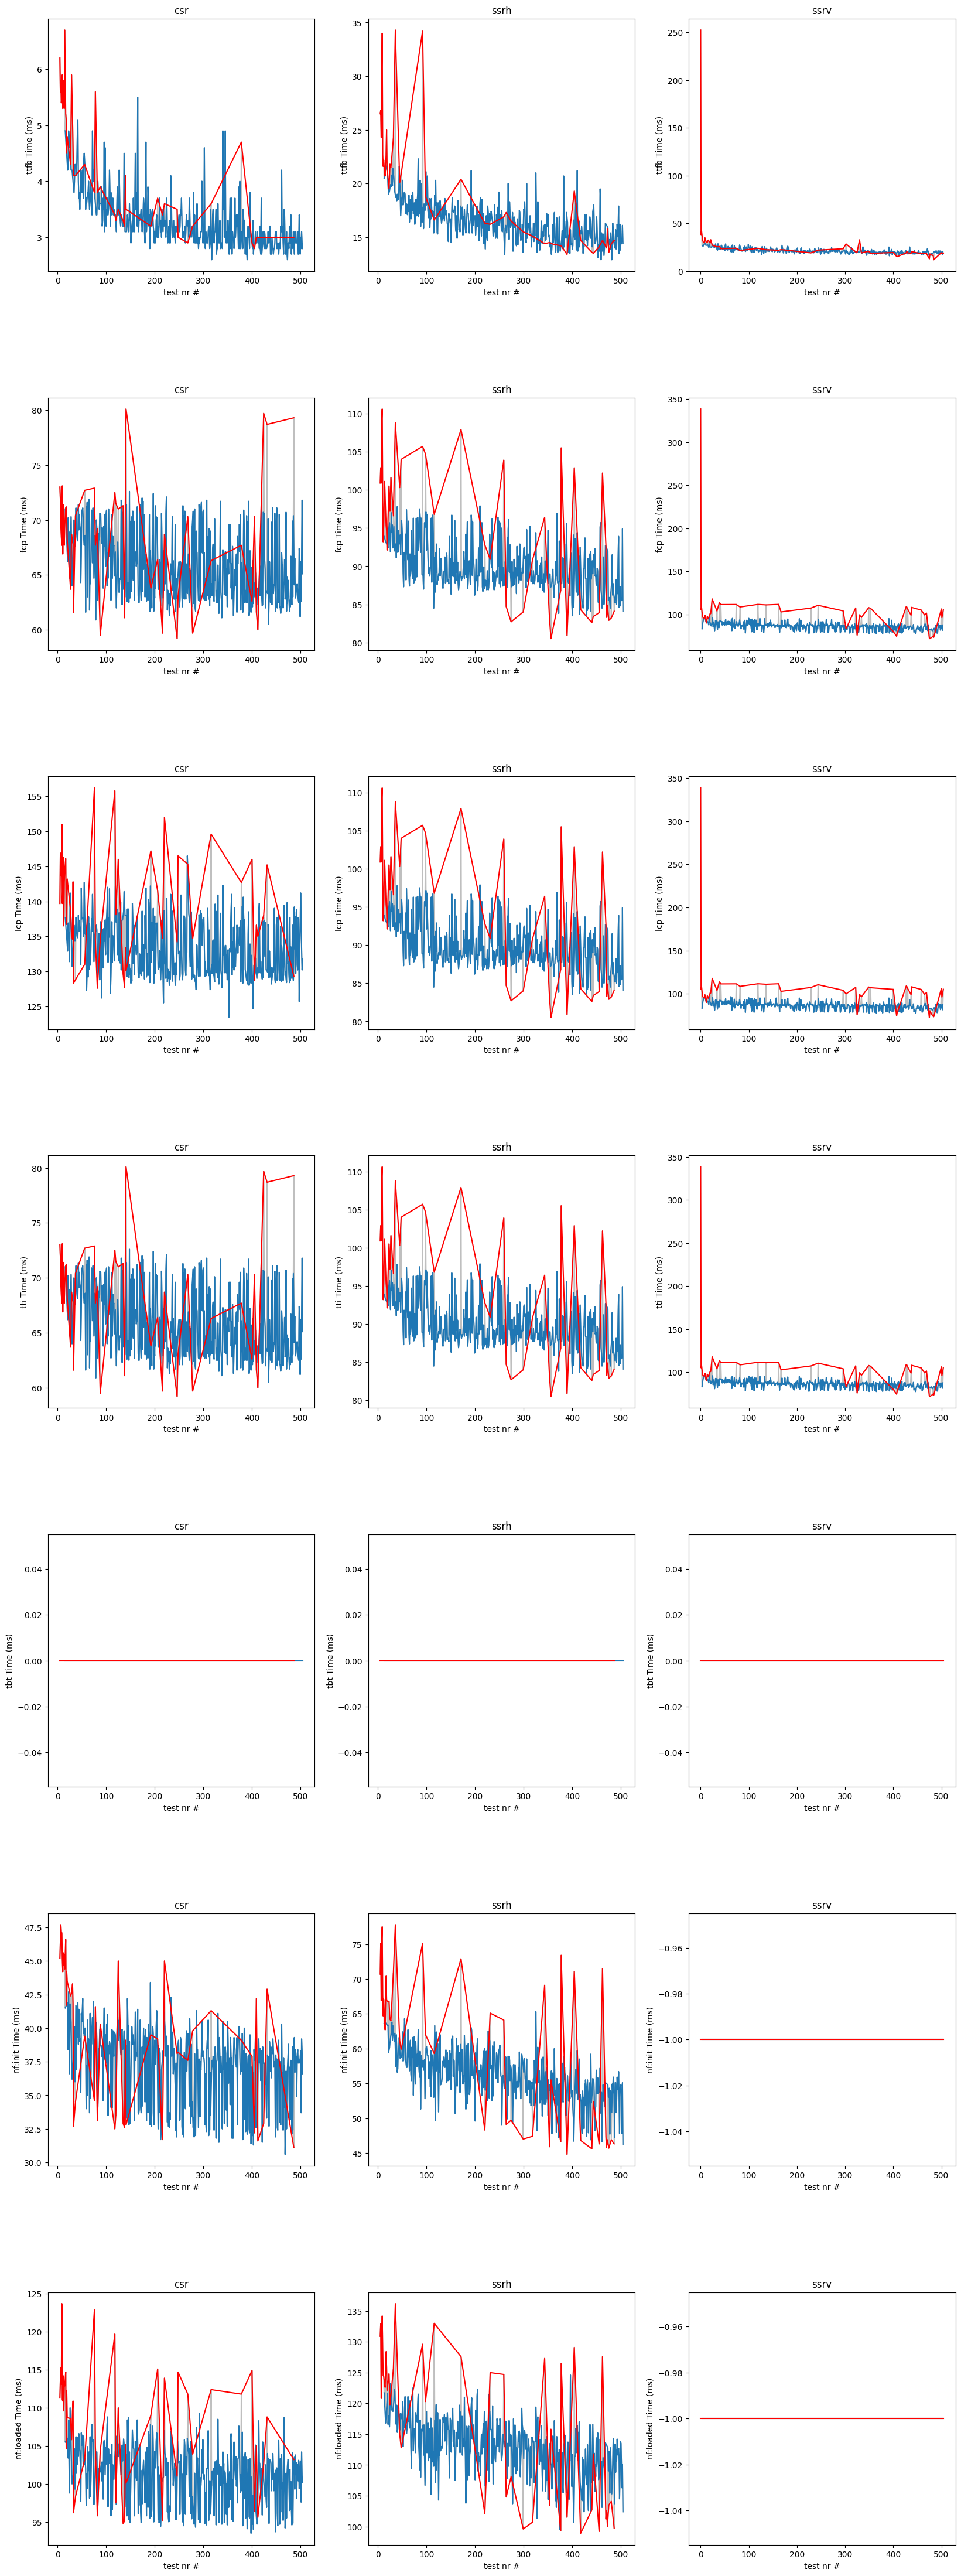

In [4]:
def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

# def plot_outliers(d, f, loc, mask):
#     loc.hist(datasets[d][f][mask[d]], bins=30, alpha=0.7, label='Inliers', edgecolor='k')
#     loc.hist(datasets[d][f][~mask[d]], bins=30, alpha=0.7, label='Outliers', color='red', edgecolor='k')
#     loc.set_title(d)
#     loc.set_ylabel('Frequency')
#     loc.set_xlabel(f'Distribution of {f}')
#     loc.legend()


def plot_outliers(d, f, loc, mask):
    loc.plot(datasets[d][f], label='dirty', color='gray', alpha=0.5)
    loc.plot(datasets[d][f][mask[d]], label=d)
    loc.plot(datasets[d][f][~mask[d]], label='outliers', color='red')

    loc.set_title(d)
    loc.set_ylabel(f'{f} Time (ms)') 
    loc.set_xlabel('test nr #') 

def visualize_outliers(features, masks, height=8):
    rows = len(features)
    cols = len(datasets)
    
    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_outliers(d, f, axes[y, x], masks)
    return plt

def print_outlier_stats(datasets, masks):
    stats = {}
    for name, df in datasets.items():
        total = len(df)
        outliers = (~masks[name]).sum()
        pct = (outliers / total) * 100
        stats[name] = {
            'total': total,
            'outliers': outliers,
            'percentage': pct
        }
    
    stats_df = pd.DataFrame({
        'Total Points': [stats[name]['total'] for name in stats],
        'Outliers': [stats[name]['outliers'] for name in stats],
        'Percentage Removed': [f"{stats[name]['percentage']:.1f}%" for name in stats]
    }, index=datasets.keys())
    
    return stats_df

masks = {}
cleaned_datasets = {}

for name, df in datasets.items():
    mask = detect_outliers(df, target_features)
    masks[name] = mask
    cleaned_datasets[name] = df[mask].copy()

print(print_outlier_stats(datasets, masks))

visualize_outliers(target_features, masks)
plt.show()

<module 'matplotlib.pyplot' from '/Users/auke/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

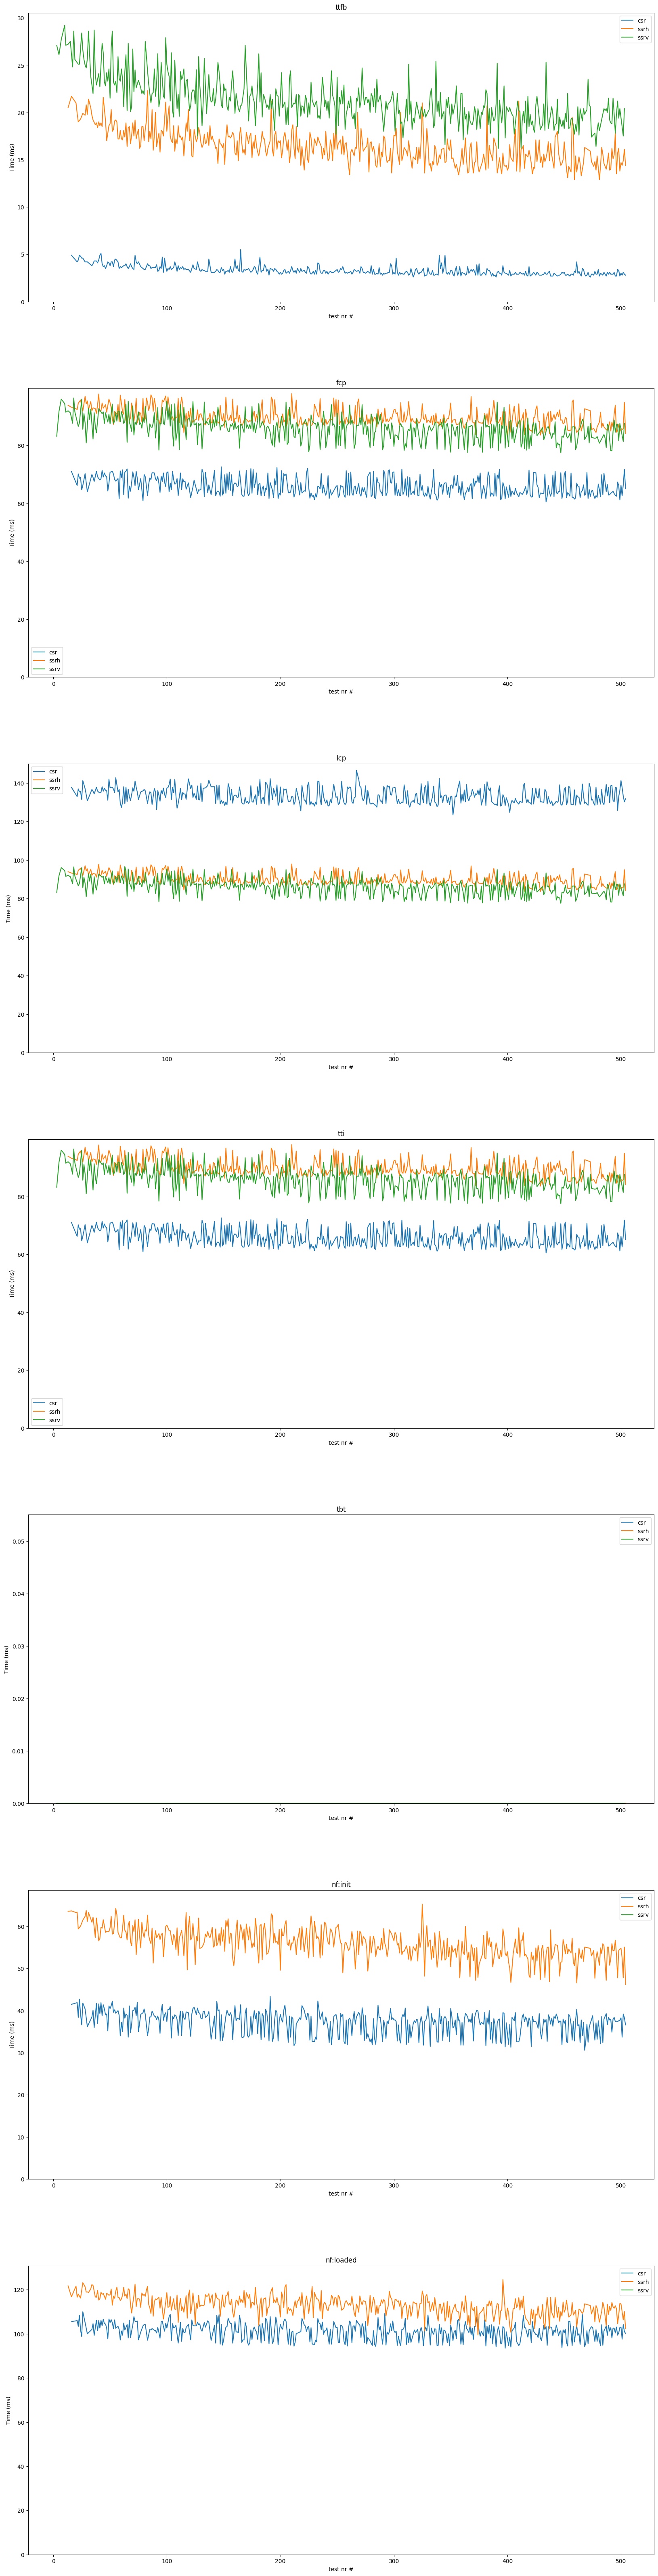

In [5]:
def ceildiv(a, b): return -(a // -b)

def plot_box_plot(f, loc):
    [loc.plot(cleaned_datasets[d][f], label=d) for d in cleaned_datasets]

    loc.set_title(f)
    loc.set_ylabel('Time (ms)') 
    loc.set_xlabel('test nr #') 
    loc.set_ylim(bottom=0)
    loc.legend()

def graphs(plot_func, features, height=10):
    rows = len(features)

    _, axes = plt.subplots(nrows=rows, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.3, top=0.95, bottom=0.05)  
    for y, f in enumerate(features):
        plot_func(f, axes[y])
    return plt

graphs(plot_box_plot, target_features)

In [6]:

keys = list(cleaned_datasets.keys())

results = pd.DataFrame([
    [metric, 'two-sided', stats.mannwhitneyu(cleaned_datasets[keys[0]][metric], 
                                   cleaned_datasets[keys[1]][metric], 
                                   alternative='two-sided')[1]]
    for metric in target_features
], columns=['metric', 'hypothesis', 'p_value'])

results['adjusted_p'] = multipletests(results['p_value'], method='bonferroni')[1]
results['significant'] = results['adjusted_p'] < 0.05

compact_format = lambda x: '%.3e' % x if x < 0.00001 else '%.5f' % x
results['p_value'] = results['p_value'].apply(compact_format)
results['adjusted_p'] = results['adjusted_p'].apply(compact_format)

results

,metric,hypothesis,p_value,adjusted_p,significant
0,ttfb,two-sided,1.002e-148,7.014e-148,True
1,fcp,two-sided,1.181e-148,8.264e-148,True
2,lcp,two-sided,1.182e-148,8.276e-148,True
3,tti,two-sided,1.181e-148,8.264e-148,True
4,tbt,two-sided,1.00000,1.00000,False
5,nf:init,two-sided,1.180e-148,8.261e-148,True
6,nf:loaded,two-sided,1.274e-136,8.919e-136,True


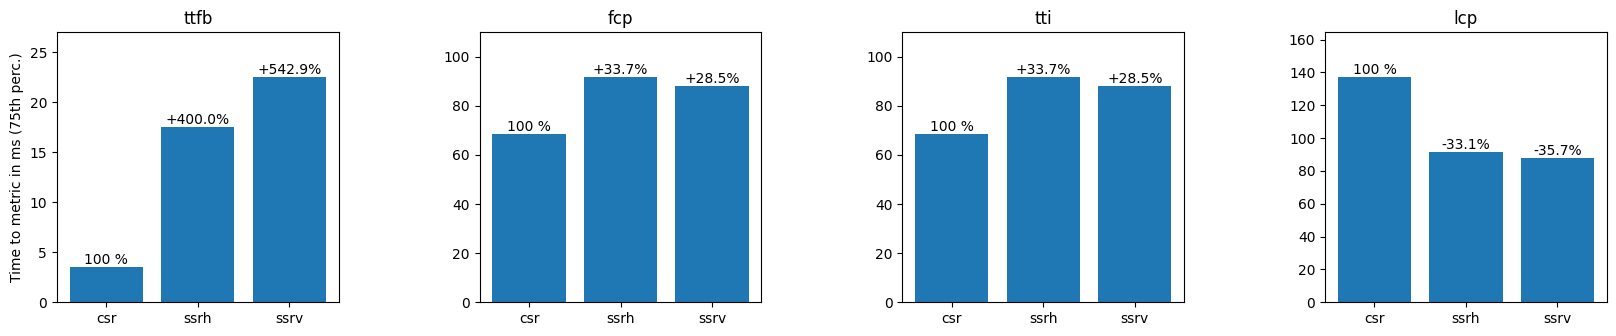

In [9]:
metrics = ['ttfb', 'fcp', 'tti', 'lcp']

def plot_bar_chart(feature, loc, show_ylabel=False):
    percentiles = {d: cleaned_datasets[d][feature].quantile(0.75) for d in datasets}
    bars = loc.bar(percentiles.keys(), percentiles.values())
    
    baseline = list(percentiles.values())[0]
    max_height = max(percentiles.values())
    
    # Add 20% padding to the top of each chart
    loc.set_ylim(0, max_height * 1.2)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = ((height / baseline) - 1) * 100
        label = f'100 %' if (i == 0) else f'{percentage:+.1f}%'
        loc.text(bar.get_x() + bar.get_width()/2., height,
                label,
                ha='center', va='bottom')
    
    loc.set_title(feature)
    if show_ylabel:
        loc.set_ylabel('Time to metric in ms (75th perc.)')

def graphs(plot_func, features, height=3):
    cols = len(features)
    _, axes = plt.subplots(ncols=cols, figsize=(20, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.5, top=0.95, bottom=0.05)
    for y, f in enumerate(features):
        # Only show ylabel for the first plot (y=0)
        plot_func(f, axes[y], show_ylabel=(y==0))
    return plt

graphs(plot_bar_chart, metrics)
plt.show()

[0 1 2]


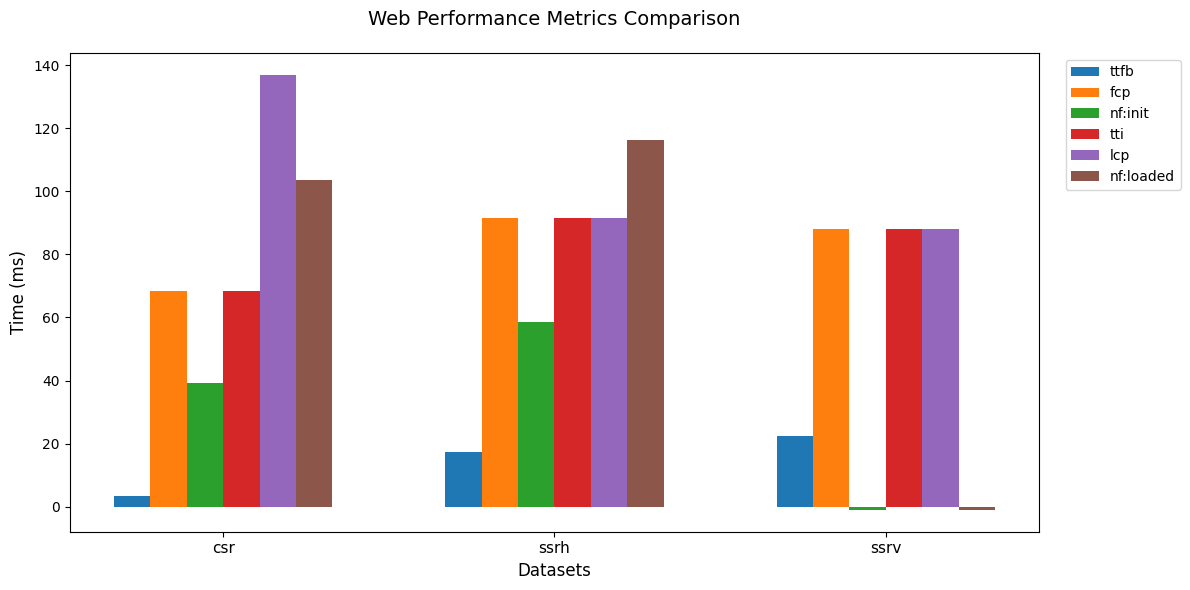

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the datasets and metrics
# datasets = ['csr', 'ssrh']
metrics = ['ttfb', 'fcp', 'nf:init', 'tti', 'lcp', 'nf:loaded']

# Create figure with larger size for better readability
plt.figure(figsize=(12, 6))

# Calculate positions
x = np.arange(len(datasets))
print(x)
bar_width = 0.11  # Reduced width to prevent overlap


# Create bars
for i, metric in enumerate(metrics):
    position = x + (i - len(metrics)/2 + 0.5) * bar_width
    values = [cleaned_datasets[dataset][metric.lower()].quantile(0.75) for dataset in datasets]
    plt.bar(position, values, bar_width, label=metric)

# Customize the plot
plt.xlabel('Datasets', fontsize=12)
plt.ylabel('Time (ms)', fontsize=12)
plt.title('Web Performance Metrics Comparison', fontsize=14, pad=20)

# Set x-axis ticks
plt.xticks(x, datasets, fontsize=11)

# Add legend with better positioning
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()